## Sudoku solver

Code to try and find a solution to a sudoku puzzle using simulated annealing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random


In [11]:
class SudokuSolve:
    '''Solves a generalised sudoku-like puzzle using a simulated annealing approach'''
    
    def __init__(self, dim=3, file='sudoku.dat',  T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1):
        
        # load grid
        self.inputgrid = np.loadtxt(file)
        self.changeable = self.inputgrid == 0
        self.dim = dim
        self.poss = np.arange(1, dim*dim+1, 1)
        self.currentgrid = np.copy(self.inputgrid)
        
        # fill in empty sites of currentgrid with integers
        self.create_first_guess()
        self.bestgrid = np.copy(self.currentgrid)
        
        #'fitness' or energy of solutions
        self.cur_fitness = self.fitness(self.currentgrid)
        self.initial_fitness = self.cur_fitness
        self.best_fitness = self.cur_fitness
        self.fitness_list = [self.cur_fitness]
        
        #annealing parameters (use defaults if not set...)
        self.T = 1.0E6 if T == -1 else T
        self.alpha = 0.999 if alpha == -1 else alpha
        self.stopping_temperature = 0.0001 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1
    
    
    def create_first_guess(self):
        '''Fill empty spots in each block with integers, such that each dim x dim block only contains unique numbers.'''
        
        #loop over the sub-blocks
        for bi in range(self.dim):
            for bj in range(self.dim):
                
                # list of possible entries...
                block_poss = self.poss[:]
                
                # creates a new array to store the current block
                block_elems=self.currentgrid[bi*self.dim:(bi+1)*self.dim, bj*self.dim:(bj+1)*self.dim]
                
                # shuffled list of numbers missing from this block
                tobeplaced = np.setdiff1d(block_poss, block_elems)
                random.shuffle(tobeplaced)

                #places missing numbers in the "0" sites
                sites = np.where(block_elems == 0)
                block_elems[sites] = tobeplaced
                
                #places the new block into the current grid
                self.currentgrid[bi*self.dim:(bi+1)*self.dim, bj*self.dim:(bj+1)*self.dim] = block_elems.reshape((3,3))
        
    

        
    def fitness(self, grid):
        '''returns the "fitness", i.e. energy of a given solution.
        For a sudoku grid this is the number of duplicates within rows or columns.
        Calculated as 2n^4 - number of unique elements in each row/column '''
        return 2*self.dim**4 - sum( len(set(grid[i, :])) + len(set(grid[:, i])) for i in range(self.dim*self.dim))
    
    
    
    def anneal(self):
        '''simulated annealing to find solution:
        repeatedly creates a new candidate solution by swapping random elements in random blocks.
        slowly decreases the temperature as the simulation proceeds'''
        
        # loop until stopping conditions are met
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter and self.best_fitness != 0:
            
            # generate a new candidate solution
            candidate = np.copy(self.currentgrid)

            # pick a random block from the candidate grid
            bi, bj = random.randint(0,self.dim,2)
            block_elems=candidate[bi*self.dim:(bi+1)*self.dim, bj*self.dim:(bj+1)*self.dim]
            change_elems=self.changeable[bi*self.dim:(bi+1)*self.dim, bj*self.dim:(bj+1)*self.dim]

            
            # list the indices of the changeable sites
            sites = np.where(change_elems == True)

            # pick two random elements and swap them
            e1, e2 = random.choice(block_elems[sites], 2, replace=False)
            site1=np.where(block_elems==e1)
            site2=np.where(block_elems==e2)
            block_elems[site1] = e2
            block_elems[site2] = e1

            # place altered block back into candidate grid
            candidate[bi*self.dim:(bi+1)*self.dim, bj*self.dim:(bj+1)*self.dim] = block_elems
            
            # accept the new candidate?
            self.accept(candidate)
            
            # update conditions
            self.T *= self.alpha
            self.iteration += 1
            
            # add current fitness to list
            self.fitness_list.append(self.cur_fitness)
            
            
            
    
    def accept(self, candidate):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = self.fitness(candidate)
        
        # probability 1 for a lower energy candidate
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness = candidate_fitness
            self.currentgrid = candidate
            
            #is the new candidate the best so far?
            if candidate_fitness < self.best_fitness:
                self.best_fitness = candidate_fitness
                self.bestgrid = candidate
        
        # otherwise accept with a probability given by the boltzmann-like term
        else:
            if np.random.random() < np.exp( - abs( candidate_fitness -self.cur_fitness) / self.T):
                self.cur_fitness = candidate_fitness
                self.currentgrid = candidate
                
    def print_grid(self, grid):
        '''Outputs a pretty grid'''
        
        fig, ax=plt.subplots()
        lim1, lim2 = 0.0, self.dim**2 
        
        for y in range(0, self.dim**2 + 1):
            ax.plot([lim1, lim2], [y,y], color='k', linewidth=1)
        for y in range(0, self.dim**2 +1, 3):
            ax.plot([lim1, lim2], [y,y], color='k', linewidth=3)
        for x in range(0, self.dim**2 + 1):
            ax.plot([x,x], [lim1, lim2], color='k', linewidth=1)
        for x in range(0, self.dim**2 +1, 3):
            ax.plot([x,x], [lim1, lim2], color='k', linewidth=3)
        
        ax.axis('image')
        ax.axis('off')
        
        for x in range(self.dim**2):
            for y in range(self.dim**2):
                # need to reverse the y-direction for plotting
                number=grid[self.dim**2 -1 -y, x] 
                
                # set different font colour for fixed/changeable numbers
                if(self.changeable[self.dim**2 -1 -y, x] ==True):
                    fntclr='gray'
                else:
                    fntclr='k'
                    
                # ignore the zeros    
                if number > 0: 
                    T=str(int(number))
                    ax.text(x+0.3,y+0.2,T,fontsize=15, color="black")
        plt.show()                
        

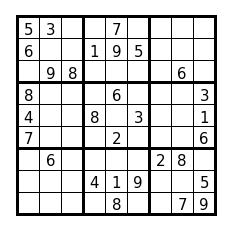

Solution not found this time! (Best fitness = 40)


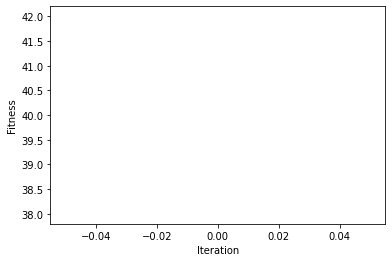

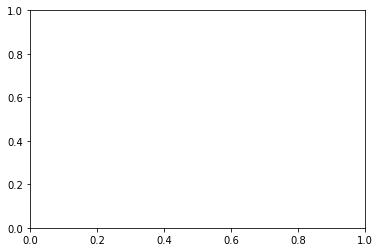

In [12]:
soln = SudokuSolve(file='/content/drive/MyDrive/Theoretical Physics 2017-2021/Computational Physics/Power/sudoku2.dat', T=0.1, alpha=0.9999, stopping_T=0.0002, stopping_iter=20000)
soln.print_grid(soln.inputgrid)
#soln.anneal()
if soln.fitness(soln.bestgrid) == 0:
    print('Solution:')
    soln.print_grid(soln.bestgrid)
else:
    print("Solution not found this time! (Best fitness = %d)" % (soln.fitness(soln.bestgrid)))

fig2, ax=plt.subplots()
ax.plot([i for i in range(len(soln.fitness_list))], soln.fitness_list)
ax.set_xlabel('Iteration')
ax.set_ylabel('Fitness')

fig3, ax=plt.subplots()

plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
